In this tutorial, we will introduce the following content: <br>
1. Prepare demo data<br>
2. Prepare the settings<br>
3. Train and test model<br>
4. Export onnx<br>

If you want to inference pretrained model only, you can refer to <br>
 Inference PreTrained.ipynb <br>

# Download a demo dataset

In [ ]:
# package fiftyone is an open-source tool designed to help you work with datasets, offering free images and annotations

In [1]:
import fiftyone.zoo as foz

# here we choose detection and segmentation as our task, and set cute tortoises and lizards which like hiding as the objects to find
foz.load_zoo_dataset(
    "open-images-v7",
    split="train",
    label_types=["detections", "segmentations"],
    classes = ["Tortoise", "Lizard"],
)

foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",
    label_types=["detections", "segmentations"],
    classes = ["Tortoise", "Lizard"],
)

!mv ~/fiftyone dataset

Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'open-images-v7-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'open-images-v7-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [2]:
# write a function that loads the dataset into detectron2's standard format
# if your dataset is not in the same format, you need to revise the code of this part
import os
import pandas as pd
import cv2
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog

def get_dataset_dicts(path):
    classes = ["Tortoise", "Lizard"]
    image_path = os.path.join(path, "data/")
    image_list = [f for f in os.listdir(image_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    #load the class id
    class_path = os.path.join(path, "metadata/classes.csv")
    #load the labels 
    label_path = os.path.join(path, "labels/detections.csv")
    
    class_df = pd.read_csv(class_path, header=None)
    label_df = pd.read_csv(label_path)
    #find the id of our tortoise and lizard in the csv
    def get_code_by_name(df, name_list):
        return [df.loc[df.loc[:,1] == val, 0].values[0] for val in name_list]
    class_id = get_code_by_name(class_df, classes)
    image_list_no_ext = [img.split('.')[0] for img in image_list]
    label_df = label_df[label_df["ImageID"].isin(image_list_no_ext)]
    label_df = label_df[label_df["LabelName"].isin(class_id)]

    dataset_dicts = []
    for i,j in zip(image_list,image_list_no_ext):
        record = {}
        filename = os.path.join(image_path, i)
        height, width = cv2.imread(filename).shape[:2]
    
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width
    
        sub_label_df = label_df[label_df["ImageID"]==j]
        objs = []
        #convert box relative position to absolute position (by pixel)
        for index, row in sub_label_df.iterrows():
            obj = {
              'bbox': [int(row['XMin']*width), int(row['YMin']*height), int(row['XMax']*width), int(row['YMax']*height)],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': class_id.index(row['LabelName']),
              "iscrowd": 0}
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [3]:
# register the dataset
for d in ["train","val"]: 
    DatasetCatalog.register("turnliz_" + d, lambda d=d: get_dataset_dicts("dataset/fiftyone/open-images-v7/"+ d+"/"))
    MetadataCatalog.get("turnliz_" + d).set(thing_classes=["Tortoise", "Lizard"])
turnliz_metadata = MetadataCatalog.get("turnliz_train")

In [4]:
turnliz_metadata

namespace(name='turnliz_train', thing_classes=['Tortoise', 'Lizard'])

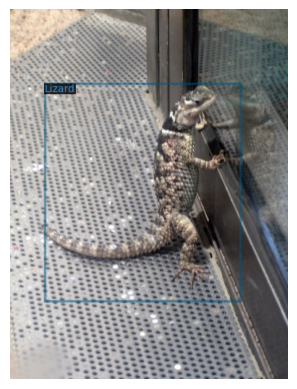

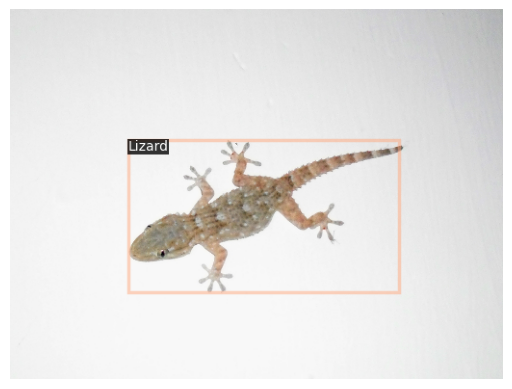

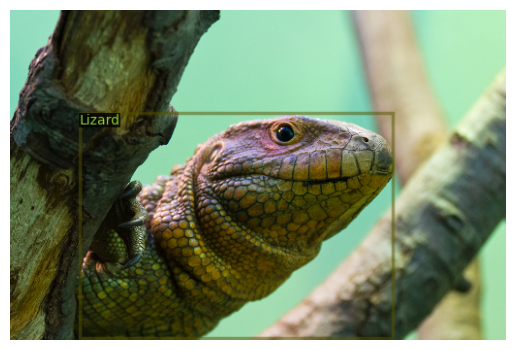

In [5]:
# lets see some samples of the dataset
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
dataset_dicts = get_dataset_dicts("dataset/fiftyone/open-images-v7/train/")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=turnliz_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    #cv2_imshow(out.get_image()[:, :, ::-1])
    im = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors
    plt.imshow(im)
    plt.axis("off")  # Hide axes
    plt.show()

# Train our model

There are plenty of models available, you can go to <br>
detectron2/detectron2/model_zoo/configs/ <br>
to choose a model <br>
name "my_yaml" as the location of the yaml  <br>
Check <br>
https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md <br>
for details of models

In [6]:
# e.g.
my_yaml = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"

In [7]:
# start training !!
# you may revise the configs to meet your custom needs
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(my_yaml))
cfg.DATASETS.TRAIN = ('turnliz_train',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(my_yaml)
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 2 classes. (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/07 10:59:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:07, 32.8MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_

[05/07 10:59:34 d2.engine.train_loop]: Starting training from iteration 0


/home/z890/.conda/envs/d2d/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4313.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/07 10:59:39 d2.utils.events]:  eta: 0:02:24  iter: 19  total_loss: 1.631  loss_cls: 1.083  loss_box_reg: 0.539  loss_rpn_cls: 0.005479  loss_rpn_loc: 0.009406    time: 0.1478  last_time: 0.1478  data_time: 0.0274  last_data_time: 0.0062   lr: 4.9953e-06  max_mem: 6686M
[05/07 10:59:41 d2.utils.events]:  eta: 0:02:18  iter: 39  total_loss: 1.499  loss_cls: 0.9821  loss_box_reg: 0.5074  loss_rpn_cls: 0.005381  loss_rpn_loc: 0.0104    time: 0.1411  last_time: 0.1309  data_time: 0.0043  last_data_time: 0.0032   lr: 9.9902e-06  max_mem: 6686M
[05/07 10:59:44 d2.utils.events]:  eta: 0:02:09  iter: 59  total_loss: 1.317  loss_cls: 0.7989  loss_box_reg: 0.4809  loss_rpn_cls: 0.003191  loss_rpn_loc: 0.007815    time: 0.1385  last_time: 0.1317  data_time: 0.0046  last_data_time: 0.0032   lr: 1.4985e-05  max_mem: 6686M
[05/07 10:59:47 d2.utils.events]:  eta: 0:02:04  iter: 79  total_loss: 1.198  loss_cls: 0.6407  loss_box_reg: 0.515  loss_rpn_cls: 0.004873  loss_rpn_loc: 0.01074    time: 0.13

In [8]:
# see how the trained model performs on validation images
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/07 11:01:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


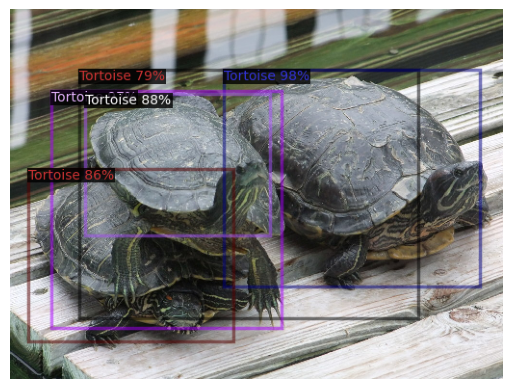

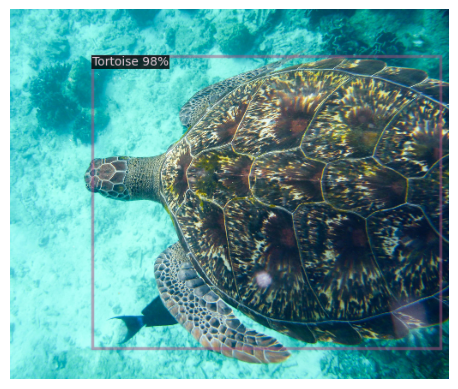

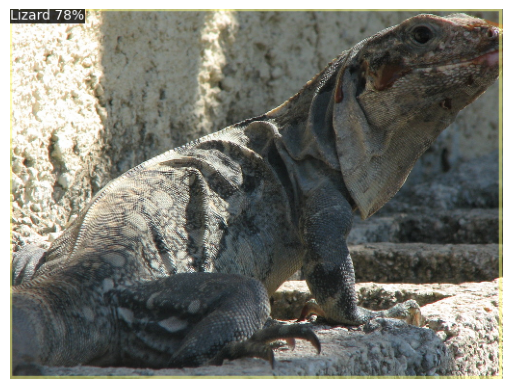

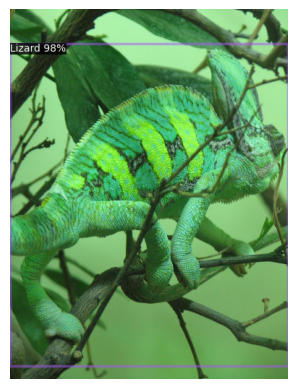

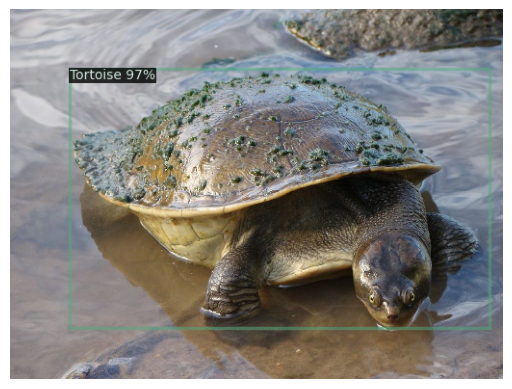

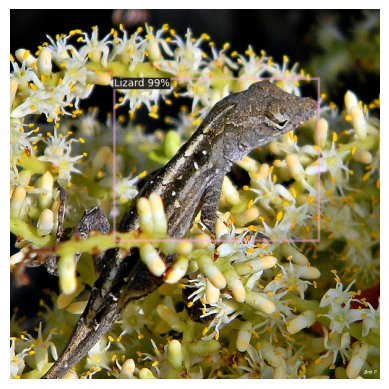

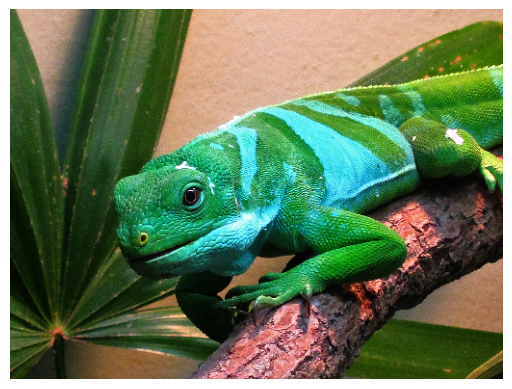

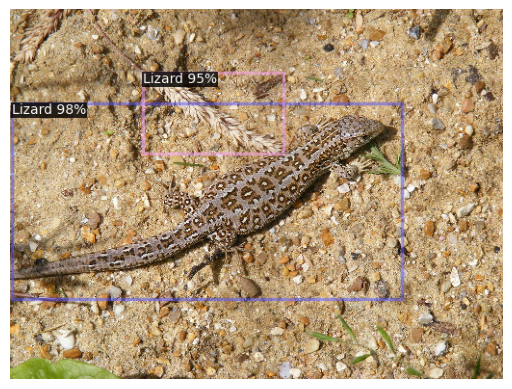

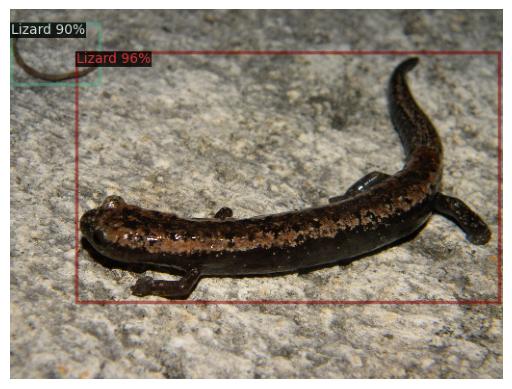

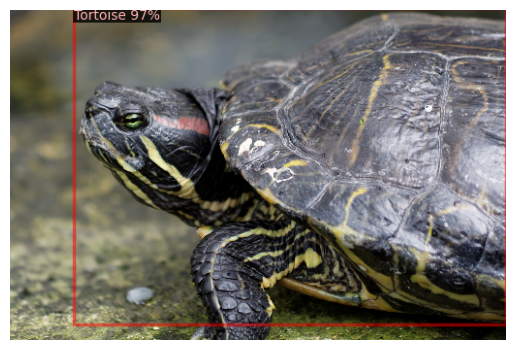

In [9]:
from detectron2.utils.visualizer import ColorMode
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
dataset_dicts = get_dataset_dicts("dataset/fiftyone/open-images-v7/validation/")
turnliz_metadataval = MetadataCatalog.get("turnliz_val")
for d in random.sample(dataset_dicts, 10):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=turnliz_metadataval,
                   scale=0.5,
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #cv2_imshow(out.get_image()[:, :, ::-1])
    im = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors
    plt.imshow(im)
    plt.axis("off")  # Hide axes
    plt.show()

# Export the model to onnx

In [10]:
import torch
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.export import TracingAdapter
from detectron2.data import build_detection_test_loader
from detectron2 import model_zoo
import os
import onnx 
import cv2

# Step 1: Load the configuration and model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(my_yaml))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.DEVICE = "cuda"
# revise to match our number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2


# Step 2: Create Pytorch Model
model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
model.eval()

# Step 3: Trace the model with appropriate inputs
#im can be any image of your training/validation dataset 
im = cv2.imread("dataset/fiftyone/open-images-v7/validation/data/0ebb1151fd4e8fe4.jpg")
im_torch = torch.as_tensor(im.astype("float32").transpose(2, 0, 1))
inputs = [{"image": im_torch}]

traceable_model = TracingAdapter(model, inputs, None)

# Step 4: Export to ONNX with appropriate dynamic axes
torch.onnx.export(traceable_model, (im_torch,), 
                  "model.onnx", 
                  opset_version=16,
                  input_names = ['image'],
                  output_names = ['instances'],
                  dynamic_axes={'image' : {1 : 'height', 2: 'width'},
                                'instances' : {0 : 'batch_size'}}
                                )

[05/07 11:01:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/z890/.conda/envs/d2d/lib/python3.10/site-packages/detectron2/structures/image_list.py:85: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t.shape[:-2] == tensors[0].shape[:-2], t.shape
/home/z890/.conda/envs/d2d/lib/python3.10/site-packages/detectron2/structures/boxes.py:151: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if tensor.numel() == 0:
/home/z890/.conda/envs/d2d/lib/python3.10/site-packages/detectron2/structures/boxes.py:155: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't recor

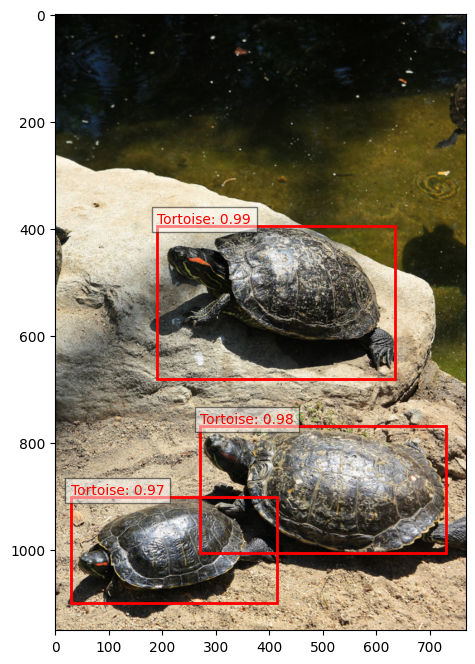

In [11]:
# try our onnx
import cv2
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt

# resize the image
def resize_shortest_edge(image, short_edge_lengths=(640, 672, 704, 736, 768, 800), max_size=1333):
    """
    Resize image such that the shorter side is randomly chosen from `short_edge_lengths`,
    while keeping the longer side ≤ max_size.
    """
    target_size = random.choice(short_edge_lengths)
    h, w = image.shape[:2]
    scale = target_size / min(h, w)
    
    if h < w:
        new_h = target_size
        new_w = int(w * scale + 0.5)
    else:
        new_w = target_size
        new_h = int(h * scale + 0.5)

    if max(new_h, new_w) > max_size:
        scale = max_size / max(new_h, new_w)
        new_h = int(new_h * scale + 0.5)
        new_w = int(new_w * scale + 0.5)

    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    return resized

# Create an ONNX Runtime session
session = ort.InferenceSession("model.onnx")

im = cv2.imread("dataset/fiftyone/open-images-v7/validation/data/d228a83a40891815.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = resize_shortest_edge(im)


# Run inference
outputs = session.run(None, {"image": im.astype("float32").transpose(2, 0, 1)})
boxes, classes, scores, size = outputs

# Set score threshold
minimum_score = 0.8

# Filter valid detections
valid_detections = scores > minimum_score
valid_boxes = boxes[valid_detections]
valid_classes = classes[valid_detections]
valid_scores = scores[valid_detections]

# Plot image
plt.figure(figsize=(8, 8))
plt.imshow(im)
ax = plt.gca()

class_name = ["Tortoise", "Lizard"]
# Draw bounding boxes with labels
for box, cls, score in zip(valid_boxes, valid_classes, valid_scores):
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{class_name[cls]}: {score:.2f}", color="red", fontsize=10, bbox=dict(facecolor="white", alpha=0.5))

plt.show()
